In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", context="notebook",font_scale=1.2)
import pandas as pd
# disable setting with copy warning
pd.options.mode.chained_assignment = None
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import matplotlib.pyplot as plt
import pydicom

In [2]:
def get_group_by_pv(pv):
    if pv == "age":
        groups = ["old", "young"]
    else:
        groups = ["male", "female"]
    return groups

In [3]:
groups = get_group_by_pv("age")
metric = (f"test/{groups[0]}_subgroupAUROC", f"test/{groups[1]}_subgroupAUROC")

In [4]:
def load_csvs_into_df(dir):
    dirs = [os.path.join(dir,d) for d in os.listdir(dir) if os.path.isdir(os.path.join(dir,d))]
    dfs = []
    sample_dfs = []
    for d in dirs:
        seeds = [f for f in os.listdir(os.path.join('./',d)) if f.startswith('seed')]
        # get last number from directory name
        train_loader_num = int(d.split('_')[-1])
        for seed in seeds:
            #print(os.path.join(d,seed))
            results = [f for f in os.listdir(os.path.join(d,seed)) if f.startswith('test_results')][0]
            sample_info = [f for f in os.listdir(os.path.join(d,seed)) if f.startswith('train_loader')][0]
            results_df = pd.read_csv(os.path.join(d, seed, results))
            sample_df = pd.read_csv(os.path.join(d, seed, sample_info))
            results_df["train_loader_num"] = train_loader_num
            sample_df["train_loader_num"] = train_loader_num
            dfs.append(results_df)
            sample_dfs.append(sample_df)
    return pd.concat(dfs, ignore_index=True), pd.concat(sample_dfs, ignore_index=True)

In [5]:
df_1_fae, df_samples_1_fae= load_csvs_into_df('./2023-10-28 18:24:29-FAE-cxr14-age-bs32-dataset-distillation-nsamples1-noDP')
df_1_fae["model"] = "FAE"


df_1_rd, df_samples_1_rd = load_csvs_into_df('./2023-10-30 02:46:30-RD-cxr14-age-bs32-dataset-distillation-nsamples1-noDP' )
df_1_rd["model"] = "RD"

In [6]:
df_1 = pd.concat([df_1_fae, df_1_rd], ignore_index=True)

In [7]:
df = df_1[['seed','protected_attr_percent',*metric,'train_loader_num','model']]
df = pd.melt(df, id_vars=['seed','protected_attr_percent','train_loader_num','model'], var_name="metric", value_name="value")
df.metric = df.metric.str.replace(metric[1],groups[1])
df.metric = df.metric.str.replace(metric[0],groups[0])
df.head()

seed  protected_attr_percent  train_loader_num model metric     value
0     1                     0.5              1068   FAE    old  0.493872
1     1                     0.5              1071   FAE    old  0.493872
2     1                     0.5               502   FAE    old  0.480730
3     1                     0.5              1218   FAE    old  0.493872
4     1                     0.5               201   FAE    old  0.493872

Text(0.5, 1.0, 'Performance of FAE and RD trained on CXR14; single samples')

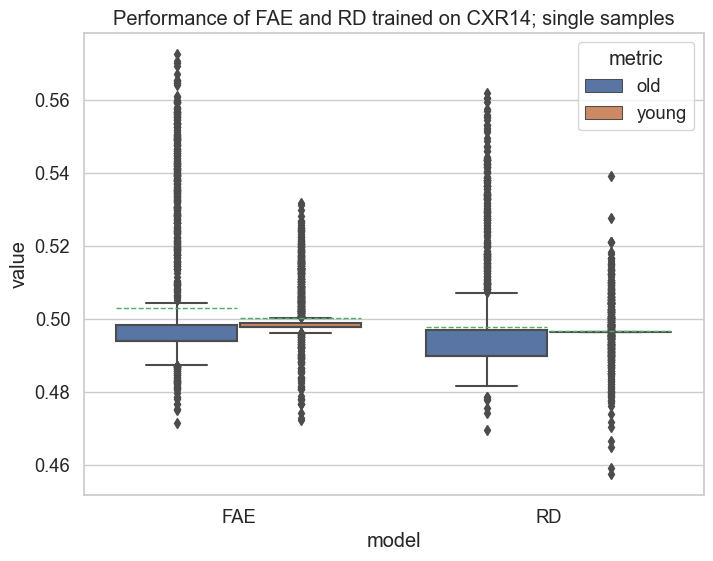

In [8]:
plt.figure(figsize=(8,6))
g = (sns.boxplot(data=df, x="model", y="value", hue="metric", meanline=True, showmeans=True))
# legend outside
g.set_title("Performance of FAE and RD trained on CXR14; single samples")

In [9]:
def get_best_and_worst(d, d_samples, group=0, num_samples=5):
    best = d[["train_loader_num",metric[group]]].sort_values(by=metric[group], ascending=False).iloc[:num_samples]
    best.rename(columns={metric[group]:"value"}, inplace=True)
    best.sort_values(by="train_loader_num", ascending=True, inplace=True)
    best_samples = d_samples.loc[d_samples["train_loader_num"].isin(best["train_loader_num"].values)]
    best_samples.sort_values(by="train_loader_num", ascending=True, inplace=True)
    
    worst = d[["train_loader_num",metric[group]]].sort_values(by=metric[group], ascending=True).iloc[:num_samples]
    worst.rename(columns={metric[group]:"value"}, inplace=True)
    worst.sort_values(by="train_loader_num", ascending=True, inplace=True)
    worst_samples = d_samples.loc[d_samples["train_loader_num"].isin(worst["train_loader_num"].values)]
    worst_samples.sort_values(by="train_loader_num", ascending=True, inplace=True)
    return best, best_samples, worst, worst_samples

In [10]:
def plot_xrays(d, d_samples, num_imgs=5, group=0, title_prefix=""):
    fig, axs = plt.subplots(1, num_imgs, figsize=(5*num_imgs,num_imgs))
    for i in range(0,num_imgs):
        file_path = d_samples["filenames"].values[i]
        file_path = "remote_data/nih_cxr8/" + "/".join(file_path.split("/")[2:])
        file_path = "../../../" + file_path
        # read png file and add to axs[i]
        img = plt.imread(file_path)
        axs[i].imshow(img, cmap="gray")
        # add score as title
        score = d["value"].values[i] if len(d) > 1 else d["value"].values[0]
        axs[i].set_title(f"{title_prefix} {groups[group]} score: {score:.4f}")
        axs[i].grid(False)

In [11]:
def subset_by_trainloader(d,d_samples, train_loader_idx=0):
    chosen_train_loader_num = d.iloc[train_loader_idx]["train_loader_num"]
    d_samples = d_samples.loc[d_samples["train_loader_num"]==chosen_train_loader_num]
    d = d.loc[d["train_loader_num"]==chosen_train_loader_num]
    return d, d_samples

# Details num_samples=1
## FAE

      train_loader_num     value
690                 21  0.572422
1070               774  0.570590
942                931  0.569308
732               1000  0.570156
357               1195  0.566992
      train_loader_num     value
369                174  0.526824
276                667  0.529840
260               1011  0.531676
724               1120  0.528284
1221              1265  0.531140


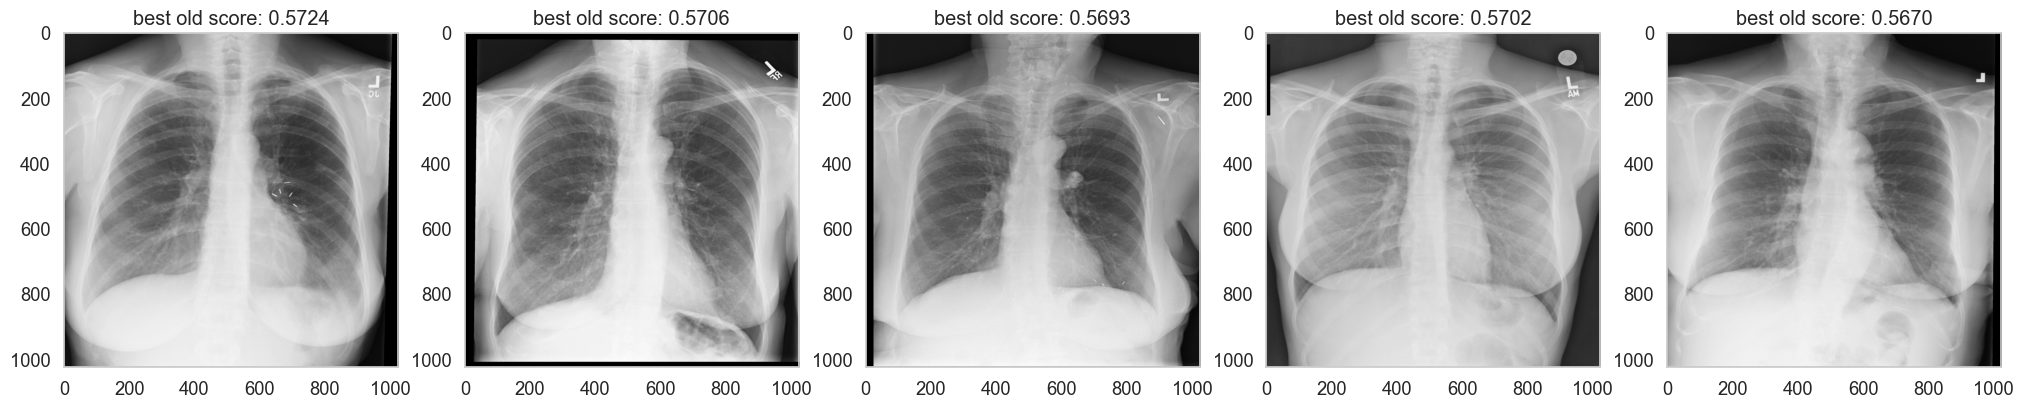

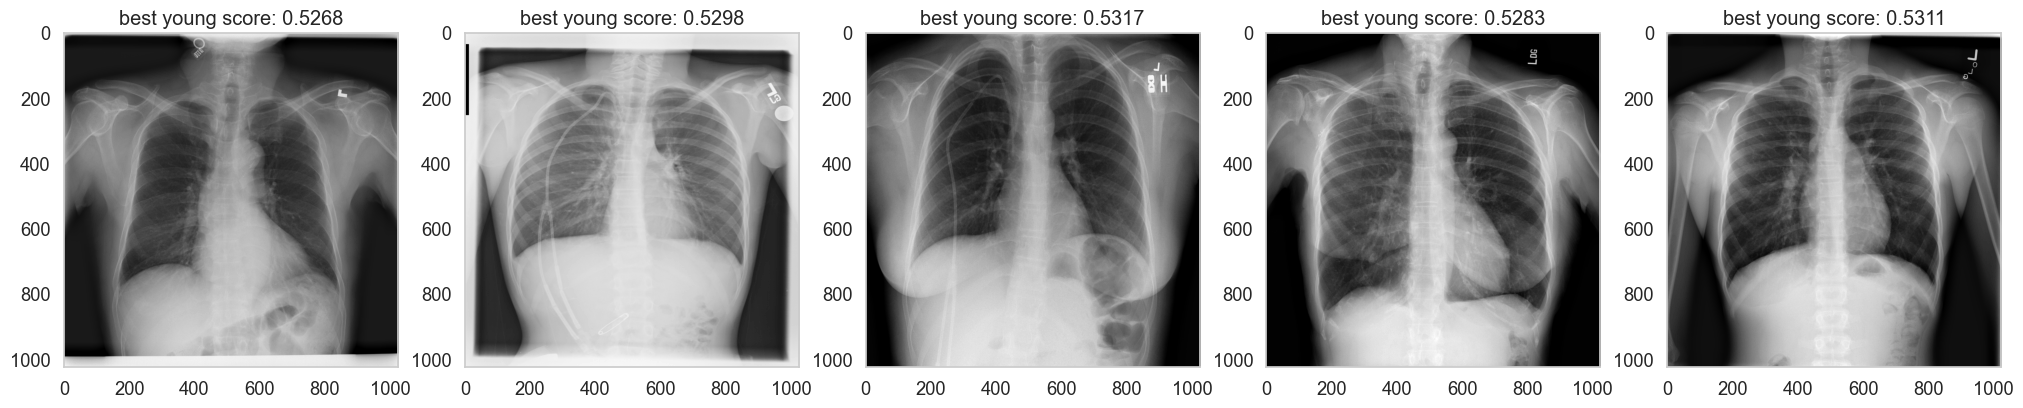

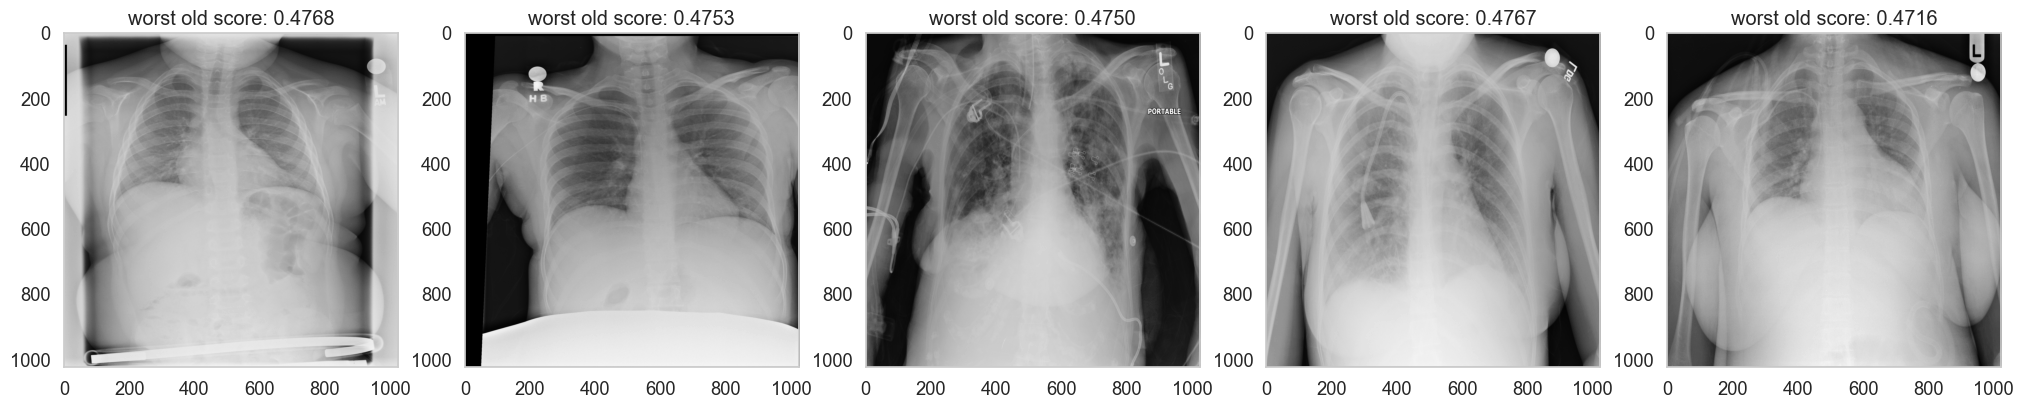

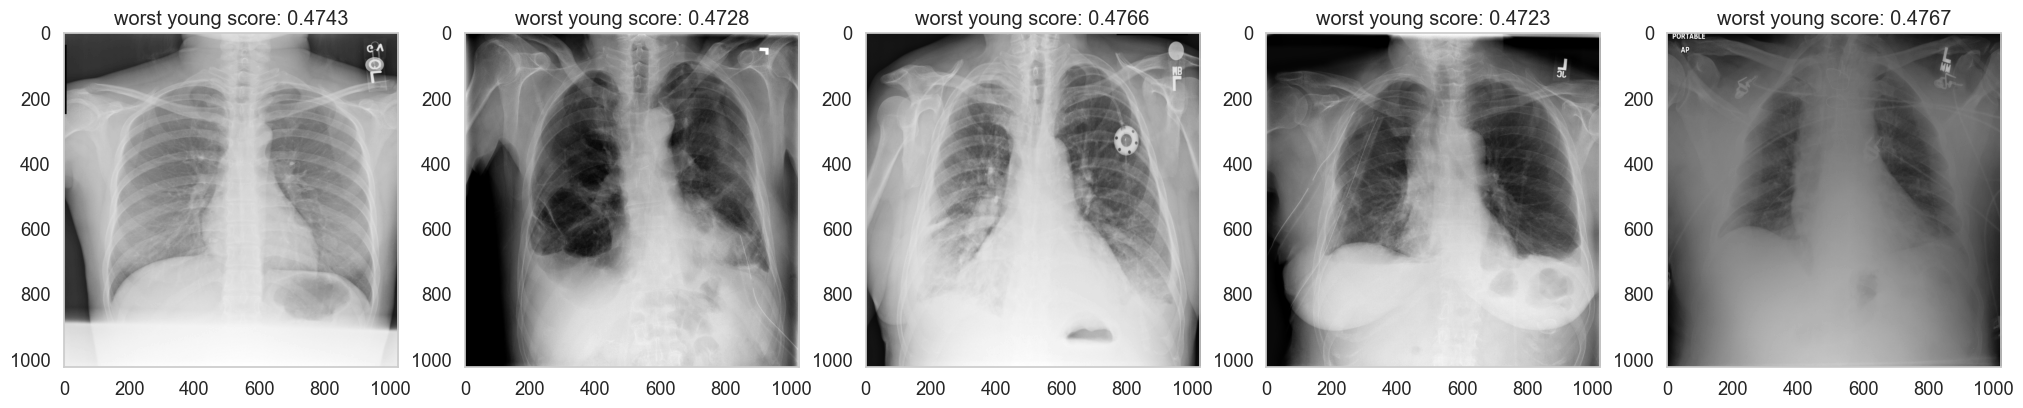

In [12]:
best_old, best_old_samples, worst_old, worst_old_samples = get_best_and_worst(df_1_fae, df_samples_1_fae, group=0)
best_young, best_young_samples, worst_young, worst_young_samples = get_best_and_worst(df_1_fae, df_samples_1_fae, group=1)
print(best_old)
print(best_young)
plot_xrays(best_old, best_old_samples, group=0, title_prefix="best")
plot_xrays(best_young, best_young_samples, group=1, title_prefix="best")
plot_xrays(worst_old, worst_old_samples, group=0, title_prefix="worst")
plot_xrays(worst_young, worst_young_samples, group=1, title_prefix="worst")

## RD

     train_loader_num     value
336                45  0.561736
781               277  0.559220
78                326  0.557432
591               377  0.560394
841               524  0.560542
     train_loader_num     value
119               506  0.539088
350               560  0.527672
543               888  0.521004
266               964  0.521068
560              1114  0.520926


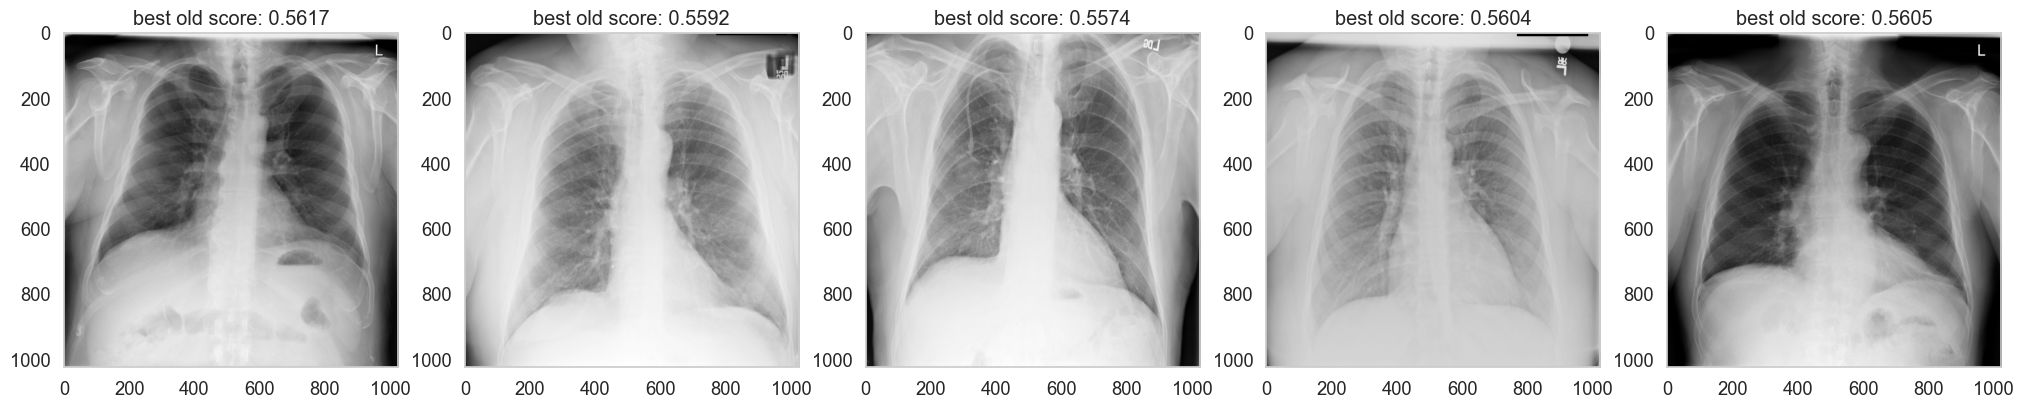

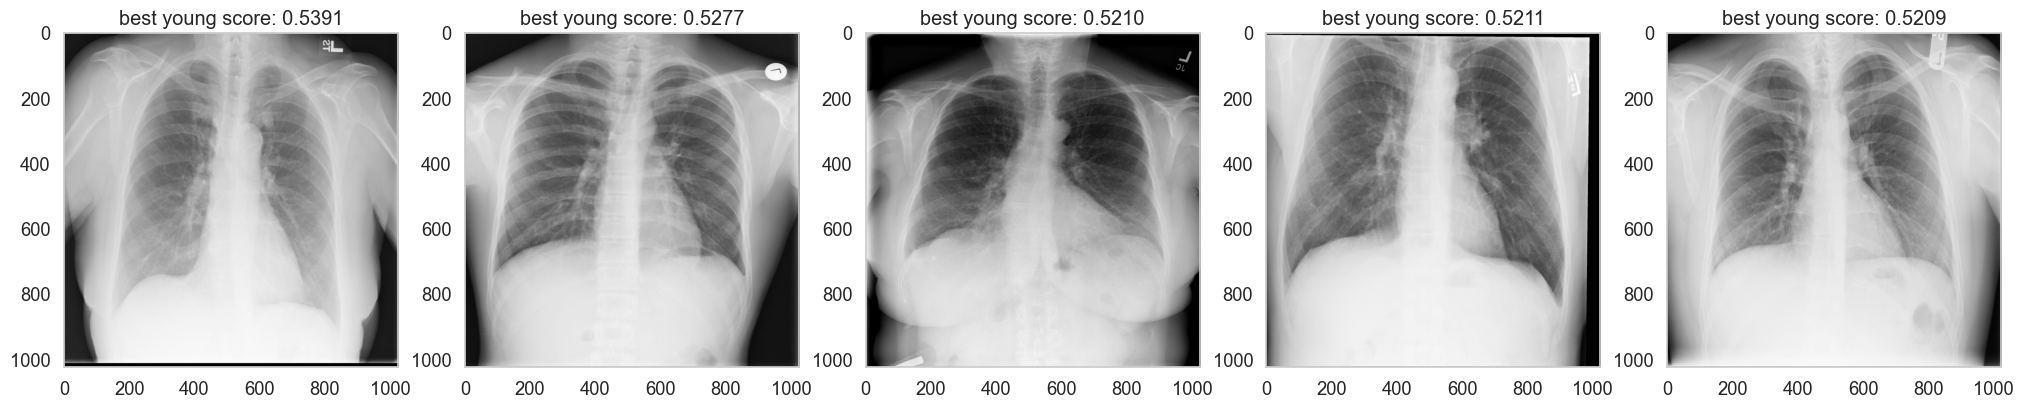

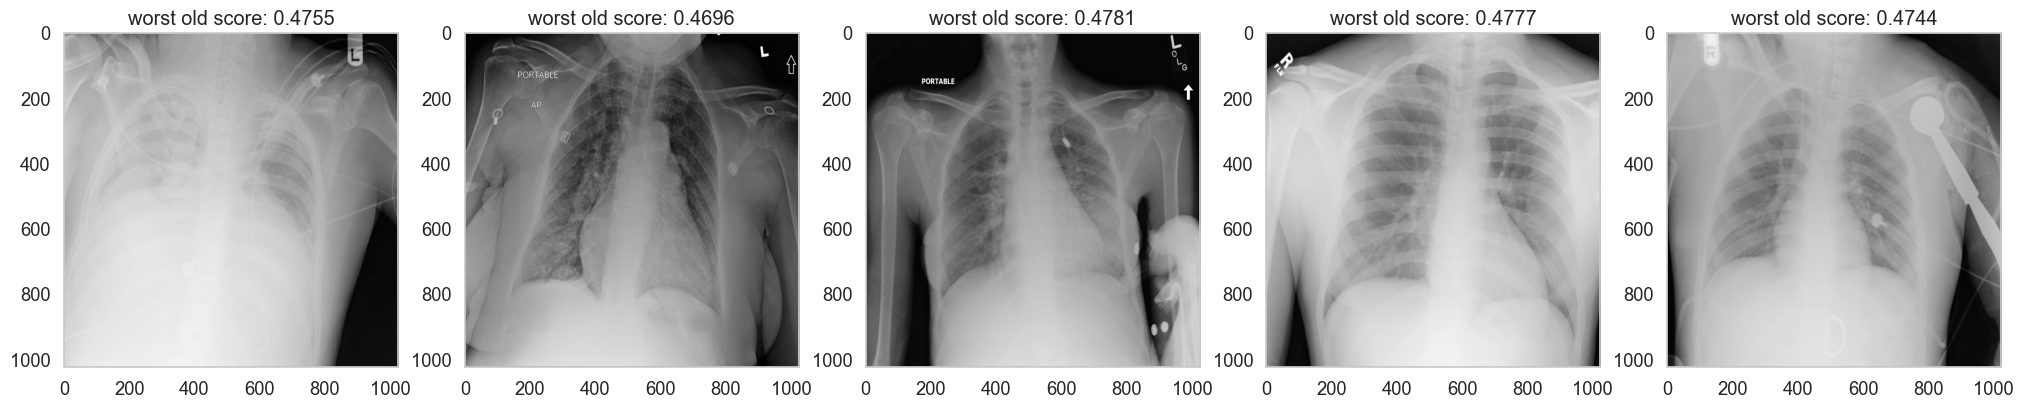

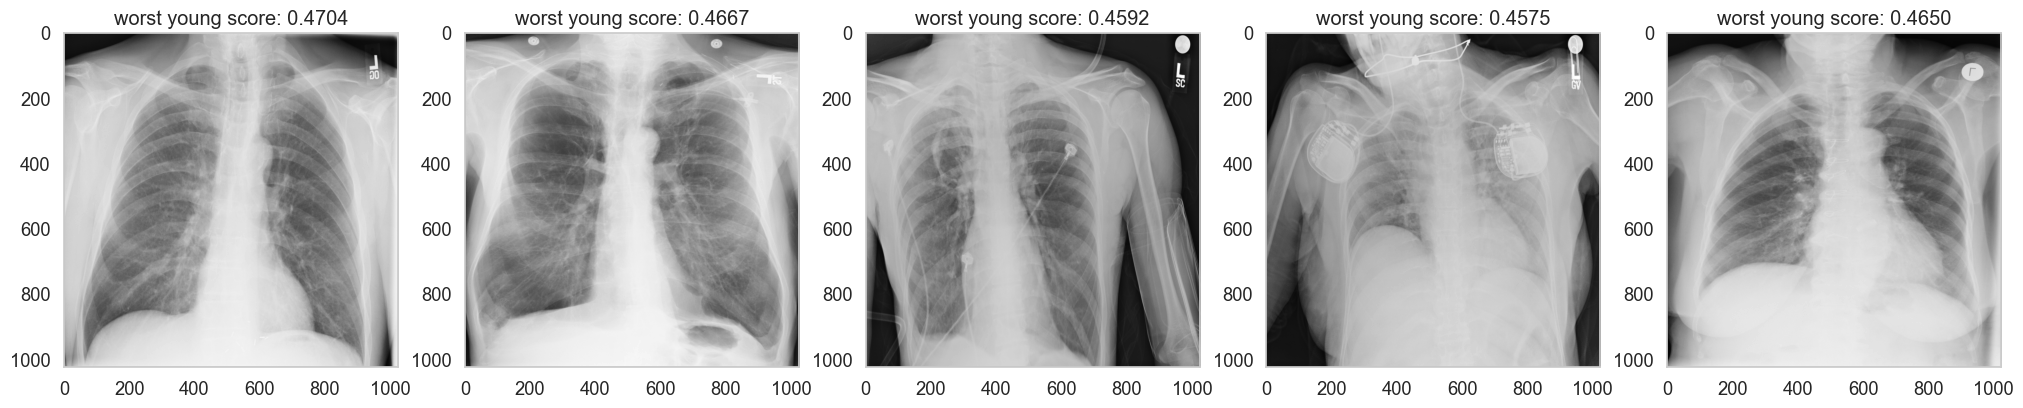

In [13]:
best_old, best_old_samples, worst_old, worst_old_samples = get_best_and_worst(df_1_rd, df_samples_1_rd, group=0)
best_young, best_young_samples, worst_young, worst_young_samples = get_best_and_worst(df_1_rd, df_samples_1_rd, group=1)
print(best_old)
print(best_young)
plot_xrays(best_old, best_old_samples, group=0, title_prefix="best")
plot_xrays(best_young, best_young_samples, group=1, title_prefix="best")
plot_xrays(worst_old, worst_old_samples, group=0, title_prefix="worst")
plot_xrays(worst_young, worst_young_samples, group=1, title_prefix="worst")

## Compute overlap

In [14]:
_, best_old_samples_rd, _, _ = get_best_and_worst(df_1_rd, df_samples_1_rd, group=0, num_samples=100)
_, best_young_samples_rd, _, _ = get_best_and_worst(df_1_rd, df_samples_1_rd, group=1, num_samples=100)

In [15]:
_, best_old_samples_fae, _, _ = get_best_and_worst(df_1_fae, df_samples_1_fae, group=0, num_samples=100)
_, best_young_samples_fae, _, _ = get_best_and_worst(df_1_fae, df_samples_1_fae, group=1, num_samples=100)

In [16]:
print("Best young samples overlap:", len(set(best_young_samples_rd["filenames"].values).intersection(set(best_young_samples_fae["filenames"].values))), "samples")

Best young samples overlap: 39 samples


In [17]:
print("Best old samples overlap:", len(set(best_old_samples_rd["filenames"].values).intersection(set(best_old_samples_fae["filenames"].values))), "samples")

Best old samples overlap: 39 samples


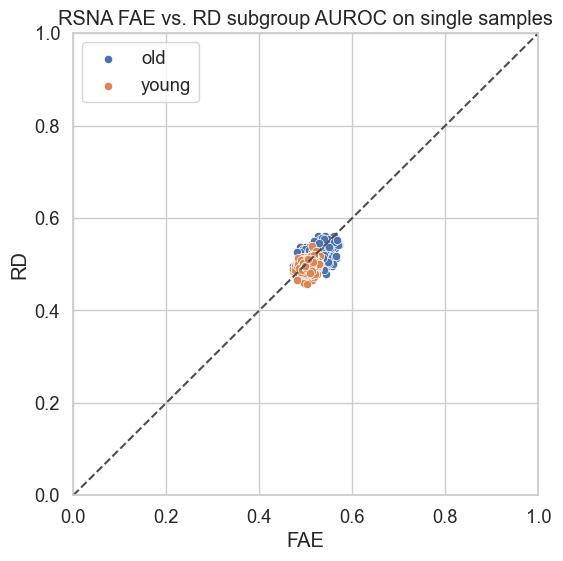

In [19]:
plt.figure(figsize=(6,6))
temp = df_1_fae[["train_loader_num",*metric]]
temp_2 = df_1_rd[["train_loader_num",*metric]]
# join on train_loader_num
temp = temp.merge(temp_2, on="train_loader_num", suffixes=("_fae", "_rd"))
temp.sort_values(by="train_loader_num", ascending=True, inplace=True)
sns.scatterplot(data=temp, x="test/old_subgroupAUROC_fae", y="test/old_subgroupAUROC_rd", label="old")
g = sns.scatterplot(data=temp, x="test/young_subgroupAUROC_fae", y="test/young_subgroupAUROC_rd", label="young")
g.set_xlim([0,1])
g.set_ylim([0,1])
g.set_title("RSNA FAE vs. RD subgroup AUROC on single samples")
plt.xlabel("FAE")
plt.ylabel("RD")
# draw diagonal
plt.plot([0, 1], [0, 1], transform=g.transAxes, ls="--", c=".3")

In [20]:
# compute correlation cofficient between sugroup scores
print("Old subgroup correlation:", temp["test/old_subgroupAUROC_fae"].corr(temp["test/old_subgroupAUROC_rd"]))
print("Young subgroup correlation:", temp["test/young_subgroupAUROC_fae"].corr(temp["test/young_subgroupAUROC_rd"]))

Old subgroup correlation: 0.7502902701837535
Young subgroup correlation: 0.28756316010531385
